In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import h5py, sys
import multiprocessing as mp
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
import itertools
from scipy.stats import norm
import time
pathtocossio = "/Users/daviddesancho/Research/code/smFSmodels"
sys.path.append(pathtocossio)
from smfsmodels import cossio
import kinetics

In [6]:
def pmf2d(xq, qk):
    H, x_edges, y_edges = np.histogram2d(data[:,1],data[:,2], \
            bins=[np.linspace(-12,12,100), np.linspace(-12,12,100)])

    fig, ax = plt.subplots(figsize=(6,5))
    pmf = np.log(H.transpose())
    pmf = pmf - np.max(pmf)
    cs = ax.contourf(pmf, extent=[x_edges.min(), x_edges.max(), y_edges.min(), y_edges.max()], cmap=cm.rainbow, )
    #pmf = -np.log(counts.transpose())
    #pmf -= np.min(pmf)

    
    #cs = ax.contourf(counts.transpose()) #, \
            #extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()], \
            #cmap=cm.rainbow, levels=np.arange(0,10 ,1))
    cbar = plt.colorbar(cs)
    ax.set_xlim(-12,12)
    ax.set_ylim(-12,12)
    ax.set_xlabel('$x$', fontsize=20)
    ax.set_ylabel('$q$', fontsize=20)
    plt.tight_layout()

In [7]:
def calc_rates(y):
    lifeA, lifeB = kinetics.calc_life([y])
    meanA = 1./np.exp(np.mean(np.log([x for x in lifeA if x>0])))
    meanB = 1./np.exp(np.mean(np.log([x for x in lifeB if x>0])))
    errorA = meanA/np.sqrt(len(lifeA))
    errorB = meanA/np.sqrt(len(lifeB))
    return np.mean([meanA, meanB]), np.mean([errorA, errorB])

In [8]:
def cossio_runner(inp):
    np.random.seed()
    kl = inp[0]
    sc = inp[1]
    numsteps = inp[2]
    
    Dq = sc*Dx
    x, q = [5., 5.]

    tt, xk, qk = cossio.run_brownian(x0=x, barrier=5., kl=kl, \
                            Dx=Dx, Dq=Dq, numsteps=numsteps, \
                                     fwrite=int(1./dt))
    data = np.column_stack((tt,xk,qk))

    h5file = "data/cossio_kl%g_Dx%g_Dq%g.h5"%(kl, Dx, Dq)
    with h5py.File(h5file, "w") as hf:
        hf.create_dataset("data", data=data)

    return h5file

In [9]:
# Globals
dt = 5e-4
Dx = 1. # Diffusion coefficient for molecular coordinate

### Molecular potential of mean force 

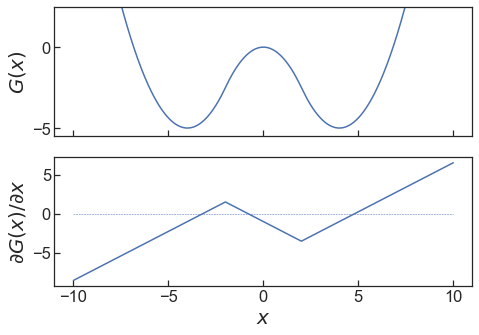

In [10]:
x = np.linspace(-10,10,1000)
fig, ax = plt.subplots(2,1, figsize=(7,5), sharex=True)
Gx = [cossio.Gx(y, barrier=5.) for y in x]
dGqxdx = [cossio.dGqxdx(0, y, barrier=5.) for y in x]
ax[0].plot(x, Gx)
ax[0].set_ylabel('$G(x)$', fontsize=20)
ax[0].set_ylim(-1.1*5,0.5*5)

ax[1].plot(x, dGqxdx)
ax[1].set_xlabel('$x$', fontsize=20)
ax[1].set_ylabel('$\partial G(x)/\partial x$', fontsize=20)
ax[1].hlines(0, -10, 10, linestyle='dashed', linewidth=0.5)

#ax[2].set_ylabel('$\partial^2 G(x)/\partial x^2$', fontsize=20)

plt.tight_layout()

### Diffusion on molecular coordinate

In [12]:
start = time.time()
x, q = [5., 0.]
t, xk, qk = cossio.run_brownian(x0=x, dt=dt, barrier=5., kl=0., \
                             Dx=Dx, numsteps=int(1e7), fwrite=int(1./dt))
end = time.time()
print (end - start)

16.011715173721313


Text(0, 0.5, 'x')

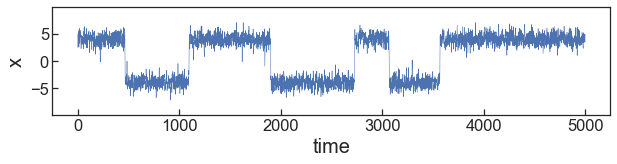

In [13]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(xk, linewidth=0.5)
ax.set_ylim(-10,10)
ax.set_yticks([-5.,0,5.])
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('x', fontsize=20)

In [15]:
rate0 = np.array(calc_rates(xk))
print (rate0)

[0.00175431 0.00090133]


Text(0.5, 0, 'x')

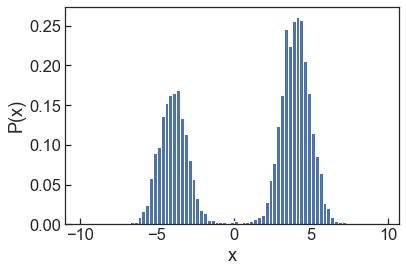

In [17]:
fig, ax = plt.subplots()
hist, bin_edges, patches = \
        ax.hist(xk, bins=np.arange(-10,10,0.25), density=True)
ax.set_ylabel('P(x)')
ax.set_xlabel('x')

<ipython-input-18-9609fcdf6522>:5: RuntimeWarning: divide by zero encountered in log
  ax.plot(bin_centers, -np.log(hist), 'red', lw=4)


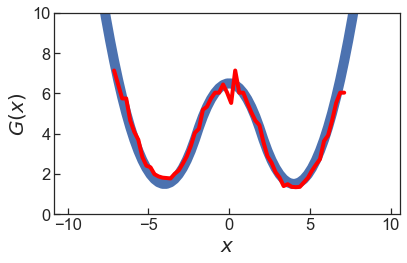

In [18]:
bin_centers = [0.5*(bin_edges[i]+bin_edges[i+1]) \
               for i in range(len(bin_edges)-1)]
fig, ax = plt.subplots()
ax.plot(bin_centers, [cossio.Gx(x) + 6.5   for x in bin_centers], lw=10)
ax.plot(bin_centers, -np.log(hist), 'red', lw=4)
ax.set_ylabel('$G(x)$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylim(0,10)
plt.tight_layout()

In [ ]:
input = [[0, 0, 1e8], [0.41, 1, 1e8], [0.41, 0.1, 1e8], [0.41, 0.01, 1e8]]

nproc = 4
pool = mp.Pool(processes=nproc)
output = pool.map(cossio_runner, input)
pool.close()
pool.join()

In [ ]:
h5file = output[0]
f = h5py.File(h5file, 'r')
data = np.array(f['data'])
f.close()

fig, ax = plt.subplots(2,1,figsize=(12,3), sharex=True,sharey=True)
ax[0].plot(data[:,0],data[:,1],'.', markersize=1)
ax[1].plot(data[:,0],data[:,2],'.', markersize=1)
ax[1].set_ylim(-10,10)
ax[1].set_xlim(0,5e4)

plt.tight_layout(h_pad=0)

In [ ]:
h5file = output[1]
f = h5py.File(h5file, 'r')
data = np.array(f['data'])
f.close()

fig, ax = plt.subplots(2,1,figsize=(12,3), sharex=True,sharey=True)
ax[0].plot(data[:,0],data[:,1],'.', markersize=1)
ax[1].plot(data[:,0],data[:,2],'.', markersize=1)
ax[1].set_ylim(-10,10)
ax[1].set_xlim(0,5e4)

plt.tight_layout(h_pad=0)

In [ ]:
h5file = output[2]
f = h5py.File(h5file, 'r')
data = np.array(f['data'])
f.close()

fig, ax = plt.subplots(2,1,figsize=(12,3), sharex=True,sharey=True)
ax[0].plot(data[:,0],data[:,1],'.', markersize=1)
ax[1].plot(data[:,0],data[:,2],'.', markersize=1)
ax[1].set_ylim(-10,10)
ax[1].set_xlim(0,5e4)

plt.tight_layout(h_pad=0)

In [ ]:
h5file = output[3]
f = h5py.File(h5file, 'r')
data = np.array(f['data'])
f.close()

fig, ax = plt.subplots(2,1,figsize=(12,3), sharex=True,sharey=True)
ax[0].plot(data[:,0],data[:,1],'.', markersize=1)
ax[1].plot(data[:,0],data[:,2],'.', markersize=1)
ax[1].set_ylim(-10,10)
ax[1].set_xlim(0,5e4)

plt.tight_layout(h_pad=0)

In [ ]:
lifetimes = []

h5file = output[0]
f = h5py.File(h5file, 'r')
data = np.array(f['data'])
f.close()
tau_f, tau_u, data_f, data_u, tp_f, tp_u, recrossings = \
       kinetics.lifetimes(data[:,[0,1]], f_bound=-2, u_bound=2)
lifetimes.append(tau_f + tau_u)

for i in range(1,4):
    h5file = output[i]
    f = h5py.File(h5file, 'r')
    data = np.array(f['data'])
    f.close()
    tau_f, tau_u, data_f, data_u, tp_f, tp_u, recrossings = \
        kinetics.lifetimes(data[:,[0,2]], f_bound=-2, u_bound=2)
    lifetimes.append(tau_f + tau_u)

In [ ]:
fig, ax = plt.subplots(4,1, figsize=(8,8), sharex=True)
histogram, bin_edges, patches = ax[0].hist(np.log(lifetimes[0]), \
                   bins=np.linspace(0,10,20), \
                   normed=True, cumulative=False)

histogram, bin_edges, patches = ax[1].hist(np.log(lifetimes[1]), \
                   bins=np.linspace(0,10,20), \
                   normed=True, cumulative=False)

histogram, bin_edges, patches = ax[2].hist(np.log(lifetimes[2]), \
            bins=np.linspace(0,10,20), \
            normed=True, cumulative=False)

histogram, bin_edges, patches = ax[3].hist(np.log(lifetimes[3]), \
            bins=np.linspace(0,10,20), \
            normed=True, cumulative=False)

In [ ]:
print [len(x) for x in lifetimes]

In [ ]:
from scipy.stats import expon
from scipy.stats import norm

fig, ax = plt.subplots(2,1)
histogram, bin_edges, patches = \
        ax[0].hist(lifetimes, \
                   bins=np.linspace(0,np.max(lifetimes),10), normed=True, cumulative=False)
ax[0].set_xlabel(r'$\tau$')

param = expon.fit(lifetimes, floc=0)
print param
x = np.linspace(0,np.max(lifetimes),200)
ax[0].plot(x, expon.pdf(x, loc=param[0], scale=param[1]), color='lightblue', lw=3)
#ax[0].set_yticks([0, 0.0004, 0.0008])

histogram, bin_edges, patches = \
        ax[1].hist([np.log(x) for x in lifetimes if x > 0], \
                   bins=np.linspace(0,12,25), normed=True)
ax[1].set_xlabel(r'ln($\tau$)')
lx = np.linspace(0,np.log(np.max(lifetimes)),2000)
pdf = 1/param[1]*np.exp(lx)*np.exp(-1/param[1]*(np.exp(lx)))
ax[1].plot(lx, pdf, color='lightblue', lw=3)
ax[1].set_xlim(2,12)
#ax[1].set_ylim(0,0.4)
#ax[1].set_yticks([0,0.2,0.4])
plt.tight_layout()